In [ ]:
!pip install -qq einops #to create patches

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.2 MB/s eta 0:00:00


In [ ]:
from google.colab import drive #mountd the drive to import the dataset
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import warnings
warnings.filterwarnings('ignore')

import os
import gc
from typing import List, Iterable

from IPython.display import clear_output
gc.enable()

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.ops import StochasticDepth

from einops import rearrange

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import cv2
from PIL import Image, ImageDraw

from sklearn.model_selection import train_test_split

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from tqdm.notebook import tqdm
from glob import glob

seed = 42
pd.set_option('display.max_colwidth', None)

In [ ]:
def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Currently using "{device.upper()}" device.')

Currently using "CUDA" device.


In [ ]:
BATCH_SIZE = 8
IMAGE_SIZE = 224
EPOCHS = 40
NUM_CLASSES = 1

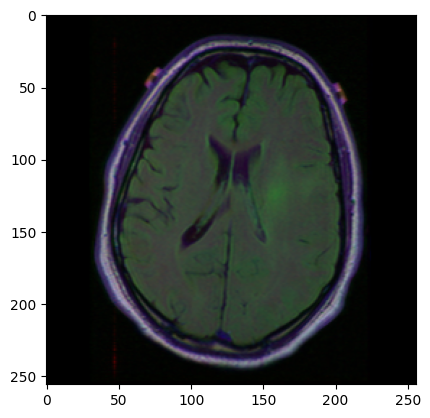

In [ ]:
mask = Image.open("/content/drive/MyDrive/Taiwan Intern/kaggle_3m/TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_10.tif")
mask = np.array(mask)[..., np.newaxis]
mask = np.repeat(mask, 3, axis=-1)

image = Image.open("/content/drive/MyDrive/Taiwan Intern/kaggle_3m/TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_12.tif")
image = np.array(image)

#image = cv2.addWeighted(image, 0.5, mask, 0.5, 0)

plt.imshow(image)
plt.show()


In [ ]:
all_paths = glob("/content/drive/MyDrive/Taiwan Intern/kaggle_3m/*/*.tif")
images_paths = sorted([path for path in all_paths if "mask" not in path])
masks_paths = sorted([path[:-9] for path in all_paths if "mask" in path])
masks_paths = [path + "_mask.tif" for path in masks_paths]
del all_paths; gc.collect()


3370

In [ ]:
data = pd.DataFrame(data={"image": images_paths, "mask": masks_paths})

x_train, x_valid = train_test_split(data, test_size=500, shuffle=True, random_state=seed)
x_test, x_valid = train_test_split(x_valid, test_size=0.5, shuffle=True, random_state=seed)
x_train = x_train.reset_index(drop=True)
x_valid = x_valid.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)

print(f"Train size: {x_train.shape[0]}, validation size: {x_valid.shape[0]}, test size: {x_test.shape[0]}")

Train size: 363, validation size: 250, test size: 250


In [ ]:
x_train.sample(5)

image  \
163  /content/drive/MyDrive/Taiwan Intern/kaggle_3m/TCGA_HT_8563_19981209/TCGA_HT_8563_19981209_12.tif   
33   /content/drive/MyDrive/Taiwan Intern/kaggle_3m/TCGA_HT_8563_19981209/TCGA_HT_8563_19981209_22.tif   
15   /content/drive/MyDrive/Taiwan Intern/kaggle_3m/TCGA_HT_8114_19981030/TCGA_HT_8114_19981030_10.tif   
307   /content/drive/MyDrive/Taiwan Intern/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_1.tif   
57   /content/drive/MyDrive/Taiwan Intern/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_55.tif   

                                                                                                       mask  
163  /content/drive/MyDrive/Taiwan Intern/kaggle_3m/TCGA_HT_8563_19981209/TCGA_HT_8563_19981209_12_mask.tif  
33   /content/drive/MyDrive/Taiwan Intern/kaggle_3m/TCGA_HT_8563_19981209/TCGA_HT_8563_19981209_22_mask.tif  
15   /content/drive/MyDrive/Taiwan Intern/kaggle_3m/TCGA_HT_8114_19981030/TCGA_HT_8114_19981030_10_mask.tif  
307   /content/drive/MyDrive/Taiwan Intern/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_1_mask.tif  
57   /content/drive/MyDrive/Taiwan Intern/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_55_mask.tif

In [ ]:
train_transforms = A.Compose([
                      A.OneOf([A.HueSaturationValue(hue_shift_limit=0.2,
                                                    sat_shift_limit=0.2,
                                                    val_shift_limit=0.2,
                                                    p=0.2),
                      A.RandomBrightnessContrast(brightness_limit=0.2,
                                                 contrast_limit=0.2,
                                                 p=0.9)],p=0.2),
                      A.ToGray(p=0.1),
                      A.OneOf(
                              [A.HorizontalFlip(p=0.5),
                               A.VerticalFlip(p=0.5),
                               A.RandomRotate90(p=0.5),
                               A.Transpose(p=0.5),
                              ], p=0.5),
                      A.OneOf([
                                A.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
                                A.GridDistortion(p=0.5),
                                A.OpticalDistortion(distort_limit=1, shift_limit=0.5, p=1),
                            ], p=0.8),
                      A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE, p=1),
                      A.Cutout(num_holes=8, max_h_size=10, max_w_size=10, fill_value=0, p=0.1),
                      A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
                      ToTensorV2(p=1.0),
                      ], p=1.0)

valid_transforms = A.Compose([
                      A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE, p=1),
                      A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
                      ToTensorV2(p=1.0),
                      ], p=1.0)

invTrans = A.Compose([A.Normalize(mean=[ 0., 0., 0. ],
                                  std=[ 1/0.229, 1/0.224, 1/0.225 ], max_pixel_value=1.0),
                      A.Normalize(mean=[ -0.485, -0.456, -0.406 ],
                                  std=[ 1., 1., 1. ], max_pixel_value=1.0),
                      ], p=1.0)

def inverse_transforms(tensor):
    if tensor.size(0) == 1 and len(tensor.shape) == 4:
        tensor.squeeze_(0)
    sample = {"image": tensor.cpu().detach().numpy().transpose(1,2,0)}
    image = invTrans(**sample)["image"]

    return image

In [ ]:
class SegDataset(Dataset):
    def __init__(self, data, transforms):
        self.data = data
        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, ix):
        row = self.data.loc[ix].squeeze()
        image = Image.open(row["image"])
        image = np.array(image)

        mask = Image.open(row["mask"])
        mask = np.array(mask)

        mask = np.where(mask > 127, 255, 0)

        sample = {"image": image, "mask": mask}
        sample = self.transforms(**sample)

        image, mask = sample["image"], sample["mask"]
        mask = mask[None, ...]

        return image, mask / 255.

    def collate_fn(self, batch):
        images, masks = list(zip(*batch))
        images, masks = [[tensor[None].to(device) for tensor in btc] for btc in [images, masks]]
        images, masks = [torch.cat(tensors) for tensors in [images, masks]]
        return images, masks

In [ ]:
train_ds = SegDataset(x_train, train_transforms)
valid_ds = SegDataset(x_valid, valid_transforms)
test_ds = SegDataset(x_test, valid_transforms)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=train_ds.collate_fn)
valid_dl = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=valid_ds.collate_fn)
test_dl = DataLoader(test_ds, batch_size=1, shuffle=False, collate_fn=test_ds.collate_fn)

In [ ]:
# https://github.com/FrancescoSaverioZuppichini/SegFormer

class LayerNorm2d(nn.LayerNorm):
    """ swap channel dim, apply layer norm and swap back: see https://github.com/pytorch/pytorch/issues/71465 """
    def forward(self, x):
        x = rearrange(x, "b c h w -> b h w c")
        x = super().forward(x)
        x = rearrange(x, "b h w c -> b c h w")
        return x

class OverlapPatchMerging(nn.Sequential):
    def __init__(
        self, in_channels: int, out_channels: int, patch_size: int, overlap_size: int
    ):
        super(OverlapPatchMerging, self).__init__(
                                        nn.Conv2d(
                                            in_channels,
                                            out_channels,
                                            kernel_size=patch_size,
                                            stride=overlap_size,
                                            padding=patch_size // 2,
                                            bias=False
                                        ),
                                        LayerNorm2d(out_channels)
                                    )

In [ ]:
class EfficientMultiHeadAttention(nn.Module):
    def __init__(self, channels: int, reduction_ratio: int = 1, num_heads: int = 8):
        super(EfficientMultiHeadAttention, self).__init__()
        self.reducer = nn.Sequential(
            nn.Conv2d(
                channels, channels, kernel_size=reduction_ratio, stride=reduction_ratio
            ),
            LayerNorm2d(channels),
        )
        self.att = nn.MultiheadAttention(
            channels, num_heads=num_heads, batch_first=True
        )

    def forward(self, x):
        _, _, h, w = x.shape
        reduced_x = self.reducer(x)
        # attention needs tensor of shape (batch, sequence_length, channels)
        reduced_x = rearrange(reduced_x, "b c h w -> b (h w) c")  # K, V
        x = rearrange(x, "b c h w -> b (h w) c")  # Q
        out = self.att(query=x, key=reduced_x, value=reduced_x)[0]
        # reshape it back to (batch, channels, height, width)
        out = rearrange(out, "b (h w) c -> b c h w", h=h, w=w)
        return out

# transformer FFN block, here fully convolutional

class MixMLP(nn.Sequential):
    def __init__(self, channels: int, expansion: int = 4):
        super(MixMLP, self).__init__(
            # linear layer
            nn.Conv2d(channels, channels, kernel_size=1),
            # depth wise conv
            nn.Conv2d(
                    channels,
                    channels * expansion,
                    kernel_size=3,
                    groups=channels,
                    padding=1,
            ),
            nn.GELU(),
            # linear layer
            nn.Conv2d(channels * expansion, channels, kernel_size=1),
        )

In [ ]:
class ResidualAdd(nn.Module):
    """ A layer that helps to add&norm MHA and FFN outputs """
    def __init__(self, fn):
        super(ResidualAdd, self).__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        out = self.fn(x, **kwargs)
        x = x + out
        return x

class SegFormerEncoderBlock(nn.Sequential):
    """ Encoder Block: not quite orthodox as not normalizing after MHA and FFN directly """
    def __init__(
                self,
                channels: int,
                reduction_ratio: int = 1,
                num_heads: int = 8,
                mlp_expansion: int = 4,
                drop_path_prob: float = .0
            ):
        super(SegFormerEncoderBlock, self).__init__(
            ResidualAdd(
                nn.Sequential(
                    LayerNorm2d(channels),
                    EfficientMultiHeadAttention(channels, reduction_ratio, num_heads),
                )
            ),
            ResidualAdd(
                nn.Sequential(
                    LayerNorm2d(channels),
                    MixMLP(channels, expansion=mlp_expansion),
                    StochasticDepth(p=drop_path_prob, mode="batch")  # https://pytorch.org/vision/main/generated/torchvision.ops.stochastic_depth.html
                )
            ),
        )

In [ ]:
class SegFormerEncoderStage(nn.Sequential):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        patch_size: int,
        overlap_size: int,
        drop_probs: List[int],
        depth: int = 2,
        reduction_ratio: int = 1,
        num_heads: int = 8,
        mlp_expansion: int = 4,
    ):
        super(SegFormerEncoderStage, self).__init__()
        self.overlap_patch_merge = OverlapPatchMerging(
            in_channels, out_channels, patch_size, overlap_size,
        )
        self.blocks = nn.Sequential(
            *[
                SegFormerEncoderBlock(
                    out_channels, reduction_ratio, num_heads, mlp_expansion, drop_probs[i]
                )
                for i in range(depth)
            ]
        )
        self.norm = LayerNorm2d(out_channels)

In [ ]:
def chunks(data: Iterable, sizes: List[int]):
    """
    Given an iterable, returns slices using sizes as indices
    """
    curr = 0
    for size in sizes:
        chunk = data[curr: curr + size]
        curr += size
        yield chunk

class SegFormerEncoder(nn.Module):
    def __init__(
        self,
        in_channels: int,
        widths: List[int],
        depths: List[int],
        all_num_heads: List[int],
        patch_sizes: List[int],
        overlap_sizes: List[int],
        reduction_ratios: List[int],
        mlp_expansions: List[int],
        drop_prob: float = .0
    ):
        super(SegFormerEncoder, self).__init__()
        # create drop paths probabilities (one for each stage's block)
        drop_probs =  [x.item() for x in torch.linspace(0, drop_prob, sum(depths))]
        self.stages = nn.ModuleList(
            [
                SegFormerEncoderStage(*args)
                for args in zip(
                    [in_channels, *widths],
                    widths,
                    patch_sizes,
                    overlap_sizes,
                    chunks(drop_probs, sizes=depths),
                    depths,
                    reduction_ratios,
                    all_num_heads,
                    mlp_expansions
                )
            ]
        )

    def forward(self, x):
        features = []
        for stage in self.stages:
            x = stage(x)
            features.append(x)
        return features

In [ ]:
# decoder
class SegFormerDecoderBlock(nn.Sequential):
    """ upsample """
    def __init__(self, in_channels: int, out_channels: int, scale_factor: int = 2):
        super(SegFormerDecoderBlock, self).__init__(
            nn.UpsamplingBilinear2d(scale_factor=scale_factor),
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
        )

class SegFormerDecoder(nn.Module):
    """ takes a list of features and returns a list of new features with the same spatial size and channels """
    def __init__(self, out_channels: int, widths: List[int], scale_factors: List[int]):
        super(SegFormerDecoder, self).__init__()
        self.stages = nn.ModuleList(
            [
                SegFormerDecoderBlock(in_channels, out_channels, scale_factor)
                for in_channels, scale_factor in zip(widths, scale_factors)
            ]
        )

    def forward(self, features):
        new_features = []
        for feature, stage in zip(features,self.stages):
            x = stage(feature)
            new_features.append(x)
        return new_features

In [ ]:
class SegFormerSegmentationHead(nn.Module):
    def __init__(self, channels: int, num_classes: int, num_features: int = 4):
        super(SegFormerSegmentationHead, self).__init__()
        self.fuse = nn.Sequential(
            nn.Conv2d(channels * num_features, channels, kernel_size=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(channels)  # paper
        )
        self.predict = nn.Conv2d(channels, num_classes, kernel_size=1)

    def forward(self, features):
        x = torch.cat(features, dim=1)  # concatenate all features obtained before (they have same spatial dims and channels)
        x = self.fuse(x)  # conv and normalize
        x = self.predict(x)  # get final feature map(s)
        return x

In [ ]:
# final model: encoder -> decoder -> head

class SegFormer(nn.Module):
    def __init__(
        self,
        in_channels: int,
        widths: List[int],
        depths: List[int],
        all_num_heads: List[int],
        patch_sizes: List[int],
        overlap_sizes: List[int],
        reduction_ratios: List[int],
        mlp_expansions: List[int],
        decoder_channels: int,
        scale_factors: List[int],
        num_classes: int,
        drop_prob: float = 0.0,
    ):

        super(SegFormer, self).__init__()
        self.encoder = SegFormerEncoder(
            in_channels,
            widths,
            depths,
            all_num_heads,
            patch_sizes,
            overlap_sizes,
            reduction_ratios,
            mlp_expansions,
            drop_prob,
        )
        self.decoder = SegFormerDecoder(decoder_channels, widths[::-1], scale_factors)
        self.head = SegFormerSegmentationHead(
            decoder_channels, num_classes, num_features=len(widths)
        )

    def forward(self, x):
        features = self.encoder(x)
        features = self.decoder(features[::-1])  # in the reverse order
        segmentation = self.head(features)
        return segmentation

In [ ]:
# check model
segformer = SegFormer(
    in_channels=3,
    widths=[64, 128, 256, 512],
    depths=[3, 4, 6, 3],
    all_num_heads=[1, 2, 4, 8],
    patch_sizes=[7, 3, 3, 3],
    overlap_sizes=[4, 2, 2, 2],
    reduction_ratios=[8, 4, 2, 1],
    mlp_expansions=[4, 4, 4, 4],
    decoder_channels=256,
    scale_factors=[8, 4, 2, 1],
    num_classes=NUM_CLASSES,
)

segmentation = segformer(torch.randn((1, 3, 224, 224)))
segmentation.shape # torch.Size([1, 2, 56, 56])

torch.Size([1, 1, 56, 56])

In [ ]:
def train_one_batch(data, model, optimizer, criterion, threshold=0.5):
    model.train()
    images, masks = data

    optimizer.zero_grad()
    out = model(images)  # [B, 1, 56, 56]
    out = nn.functional.interpolate(out, size=masks.shape[-2:], mode="bilinear", align_corners=False)  # [B, 1, 224, 224]

    loss = criterion(out, masks)  # [B, 1, 224, 224] of logits and [B, 1, 224, 224] of float zeros and ones

    loss.backward()
    optimizer.step()

    out = (torch.sigmoid(out) >= threshold).to(torch.float32)
    mask_accuracy = (out == masks).float().mean()  # binary accuracy

    return loss.item(), mask_accuracy.item()

# nn.CrossEntropyLoss()(torch.randn(8,2,224,224), msk.squeeze(1).long())  # [B, 2, 224, 224] and [B, 224, 224]

@torch.no_grad()
def validate_one_batch(data, model, criterion, threshold=0.5):
    model.eval()
    images, masks = data
    out = model(images)
    out = nn.functional.interpolate(out, size=masks.shape[-2:], mode="bilinear", align_corners=False)

    loss = criterion(out, masks)

    out = (torch.sigmoid(out) >= threshold).to(torch.float32)
    mask_accuracy = (out == masks).float().mean()

    return loss.item(), mask_accuracy.item()

@torch.no_grad()
def test_plot(model):
    model.eval()
    idx = np.random.randint(len(x_test))
    image = Image.open(x_test.iloc[idx, 0]).resize((IMAGE_SIZE, IMAGE_SIZE))
    image = np.array(image)
    sample = {"image": image}
    inputs = valid_transforms(**sample)["image"].unsqueeze(0).to(device)

    mask = Image.open(x_test.iloc[idx, 1]).resize((IMAGE_SIZE, IMAGE_SIZE))
    mask = np.array(mask)[..., np.newaxis]
    mask = np.repeat(mask, 3, axis=-1)

    masked_image = cv2.addWeighted(image, 0.5, mask, 0.5, 0)

    out = model(inputs)
    out = nn.functional.interpolate(out, size=(IMAGE_SIZE, IMAGE_SIZE), mode="bilinear", align_corners=False)
    out = torch.sigmoid(out)
    out = out.detach().cpu().numpy()[0].transpose(1,2,0)
    out = np.where(out >= 0.5, 1, 0)
    out = np.clip(out * 255, 0, 255)
    out = np.repeat(out, 3, axis=-1).astype(np.uint8)

    out_image = cv2.addWeighted(image, 0.5, out, 0.5, 0)

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10,5))
    axes[0].imshow(image)
    axes[0].set_title("Image")
    axes[1].imshow(masked_image)
    axes[1].set_title("Original Mask")
    axes[2].imshow(out_image)
    axes[2].set_title("Predicted Mask")
    plt.tight_layout()
    plt.show()

In [ ]:
class EarlyStopping:
    def __init__(self, patience=15, min_delta=0, path='model.pth'):
        self.path = path
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss, model=None):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            checkpoint = {
                'model': model,
            }
            torch.save(checkpoint, self.path)
            print(f'Model saved to: {self.path}')
            self.best_loss = val_loss
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

In [ ]:
model = SegFormer(
                in_channels=3,
                widths=[64, 128, 256, 512],
                depths=[3, 4, 6, 3],
                all_num_heads=[1, 2, 4, 8],
                patch_sizes=[7, 3, 3, 3],
                overlap_sizes=[4, 2, 2, 2],
                reduction_ratios=[8, 4, 2, 1],
                mlp_expansions=[4, 4, 4, 4],
                decoder_channels=256,
                scale_factors=[8, 4, 2, 1],
                num_classes=NUM_CLASSES,
                                        ).to(device)

criterion = nn.BCEWithLogitsLoss()  # add pos_weight? tensor of size [2,]
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, betas=(0.9, 0.999), weight_decay=0.00005)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, min_lr=1e-7, factor=0.1)
stopper = EarlyStopping(patience=8)

In [ ]:
print_feq = 100

epoch: 1 	step: 1 / 47 	train loss: 0.7046 	train accuracy: 0.4131 	time: 1742.9119 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 1 / 41 	train loss: 0.6747 	valid loss: 0.5549 	train accuracy 0.6675 	valid accuracy 0.9863


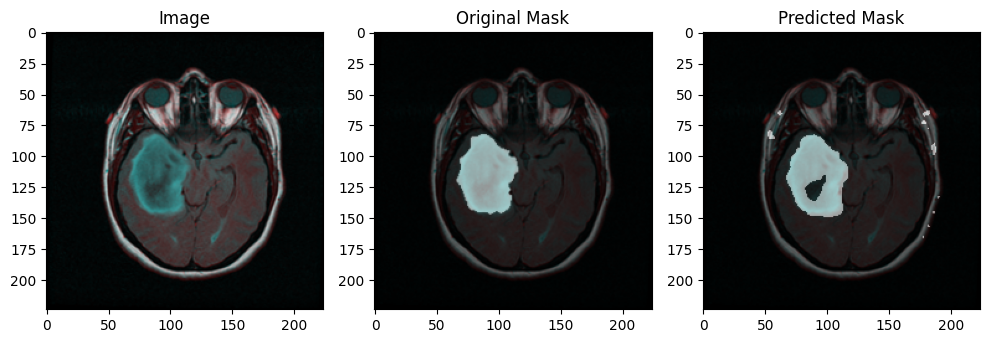

epoch: 2 	step: 1 / 47 	train loss: 0.6560 	train accuracy: 0.8198 	time: 17.8845 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 2 / 41 	train loss: 0.6496 	valid loss: 0.6749 	train accuracy 0.8234 	valid accuracy 0.6879


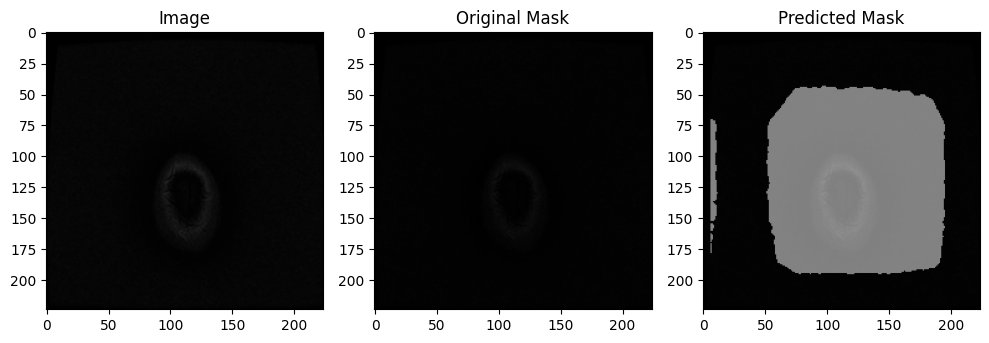

INFO: Early stopping counter 1 of 8
epoch: 3 	step: 1 / 47 	train loss: 0.6313 	train accuracy: 0.8630 	time: 16.0244 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 3 / 41 	train loss: 0.6248 	valid loss: 0.6560 	train accuracy 0.9019 	valid accuracy 0.7620


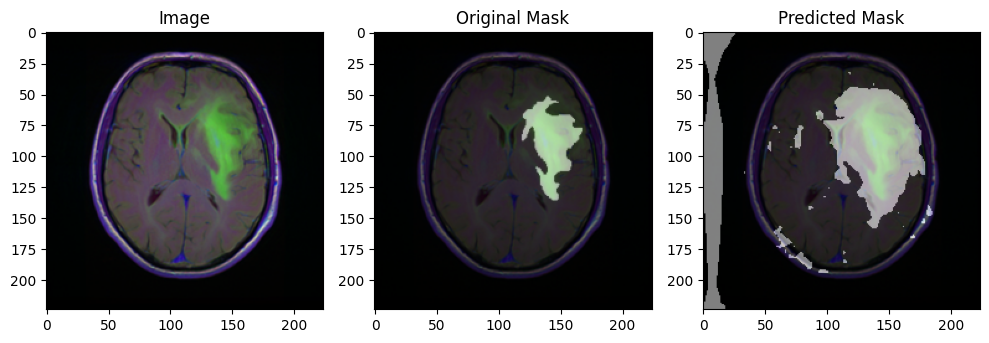

INFO: Early stopping counter 2 of 8
epoch: 4 	step: 1 / 47 	train loss: 0.6036 	train accuracy: 0.9131 	time: 25.0432 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 4 / 41 	train loss: 0.5943 	valid loss: 0.3897 	train accuracy 0.9339 	valid accuracy 0.9802


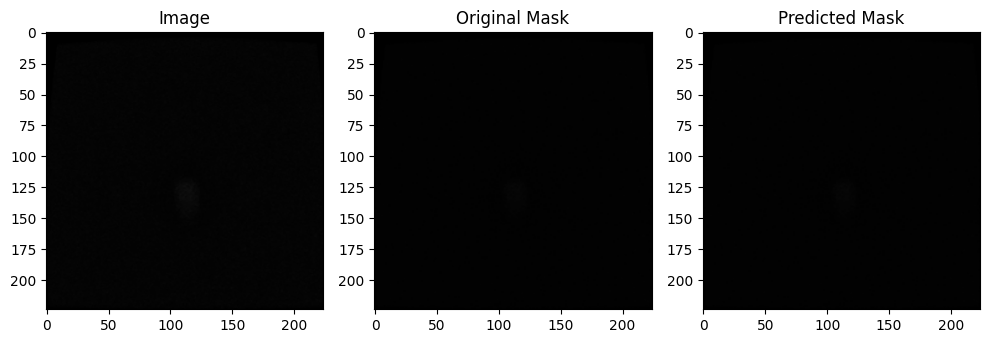

Model saved to: model.pth
epoch: 5 	step: 1 / 47 	train loss: 0.5871 	train accuracy: 0.9600 	time: 16.6427 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 5 / 41 	train loss: 0.5558 	valid loss: 0.0837 	train accuracy 0.9617 	valid accuracy 0.9890


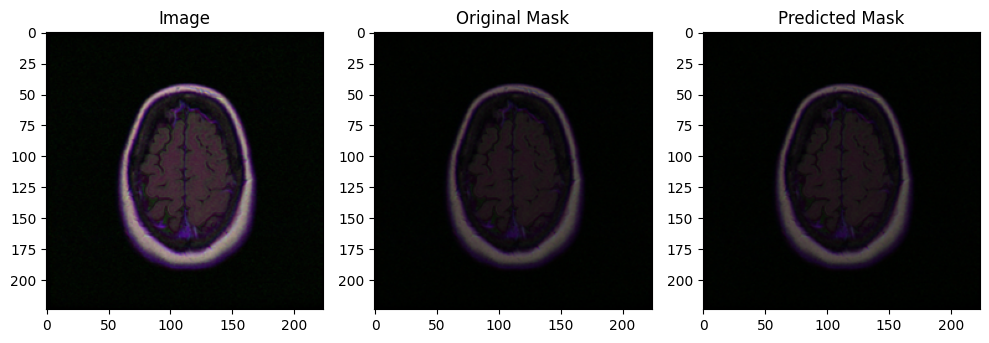

Model saved to: model.pth
epoch: 6 	step: 1 / 47 	train loss: 0.5418 	train accuracy: 0.9325 	time: 16.6805 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 6 / 41 	train loss: 0.5040 	valid loss: 0.0597 	train accuracy 0.9736 	valid accuracy 0.9905


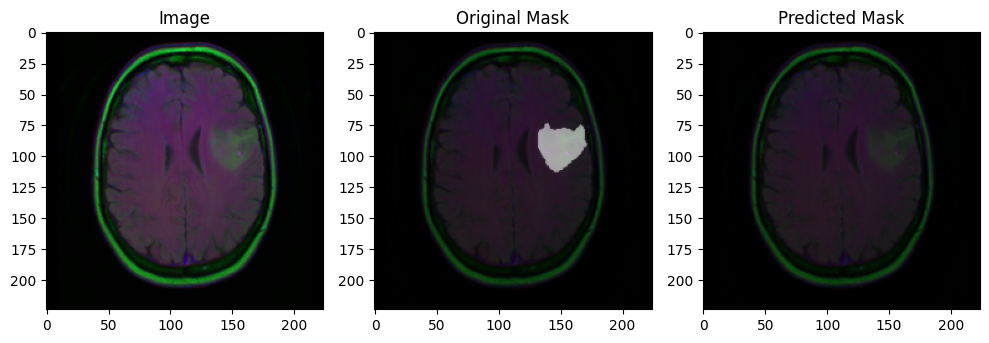

Model saved to: model.pth
epoch: 7 	step: 1 / 47 	train loss: 0.5072 	train accuracy: 0.9776 	time: 18.4698 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 7 / 41 	train loss: 0.4663 	valid loss: 1.0993 	train accuracy 0.9774 	valid accuracy 0.0221


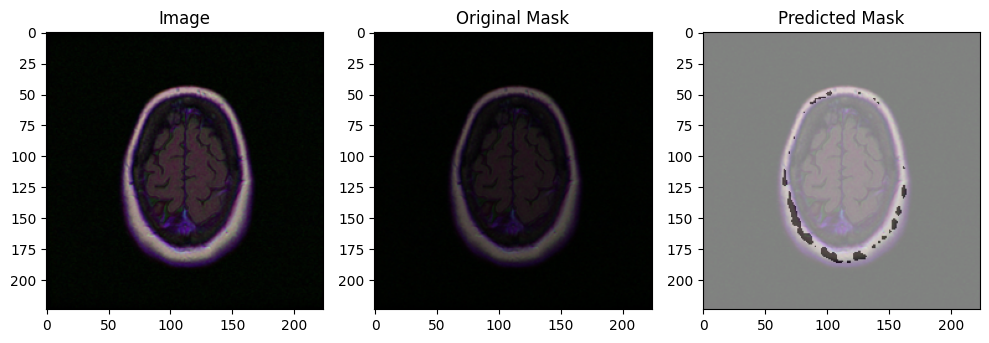

INFO: Early stopping counter 1 of 8
epoch: 8 	step: 1 / 47 	train loss: 0.3766 	train accuracy: 0.9918 	time: 16.3640 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 8 / 41 	train loss: 0.4233 	valid loss: 0.3981 	train accuracy 0.9843 	valid accuracy 0.9880


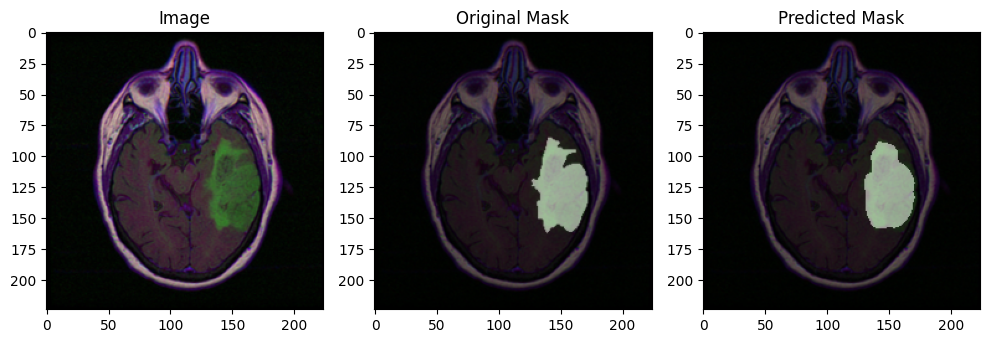

INFO: Early stopping counter 2 of 8
epoch: 9 	step: 1 / 47 	train loss: 0.4189 	train accuracy: 0.9538 	time: 16.3728 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 9 / 41 	train loss: 0.3868 	valid loss: 0.0669 	train accuracy 0.9856 	valid accuracy 0.9896


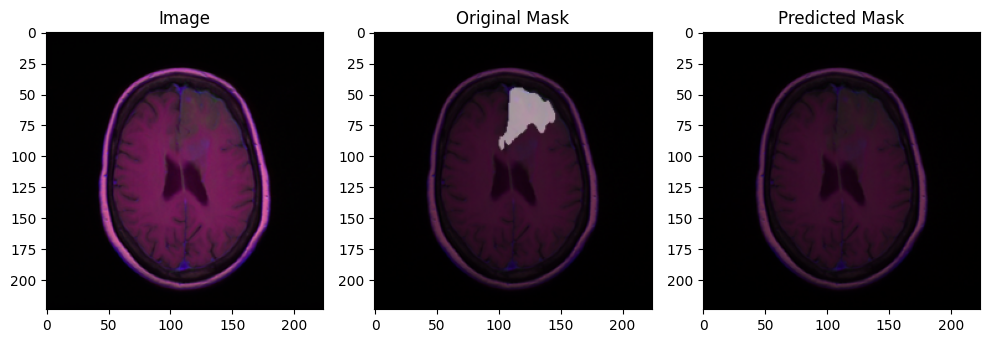

INFO: Early stopping counter 3 of 8
epoch: 10 	step: 1 / 47 	train loss: 0.3709 	train accuracy: 0.9944 	time: 16.4042 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 10 / 41 	train loss: 0.3458 	valid loss: 0.5908 	train accuracy 0.9887 	valid accuracy 0.9549


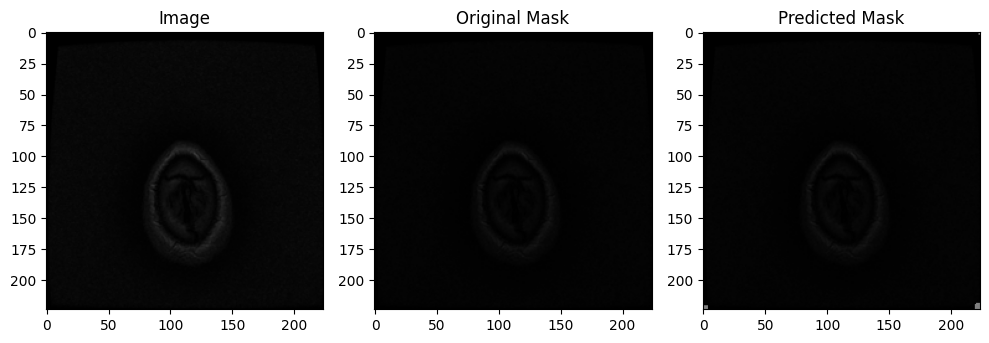

INFO: Early stopping counter 4 of 8
epoch: 11 	step: 1 / 47 	train loss: 0.3198 	train accuracy: 0.9874 	time: 25.1935 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 11 / 41 	train loss: 0.3046 	valid loss: 0.1493 	train accuracy 0.9891 	valid accuracy 0.9904


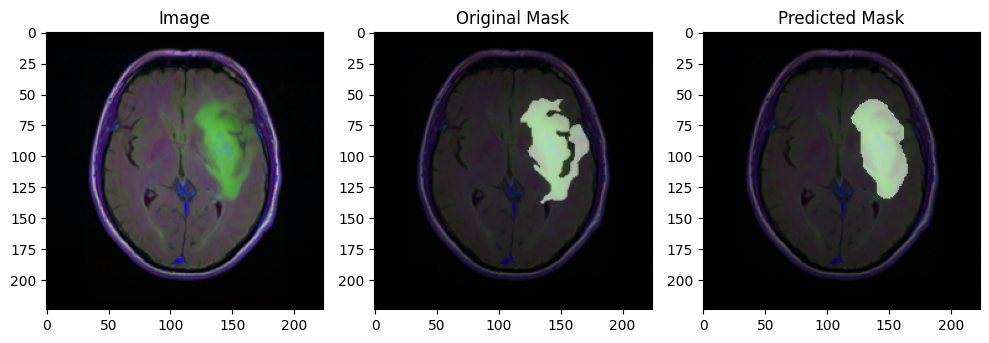

INFO: Early stopping counter 5 of 8
epoch: 12 	step: 1 / 47 	train loss: 0.2723 	train accuracy: 0.9873 	time: 24.3993 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 12 / 41 	train loss: 0.2517 	valid loss: 0.0845 	train accuracy 0.9881 	valid accuracy 0.9903


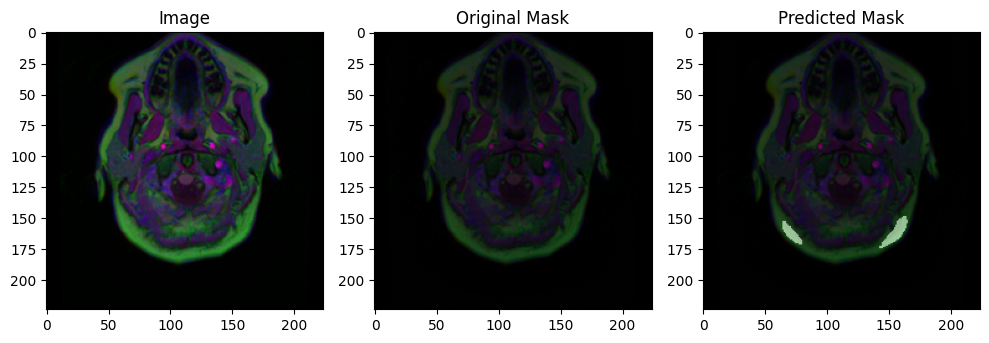

INFO: Early stopping counter 6 of 8
epoch: 13 	step: 1 / 47 	train loss: 0.2457 	train accuracy: 0.9764 	time: 16.6844 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 13 / 41 	train loss: 0.2339 	valid loss: 0.2025 	train accuracy 0.9907 	valid accuracy 0.9898


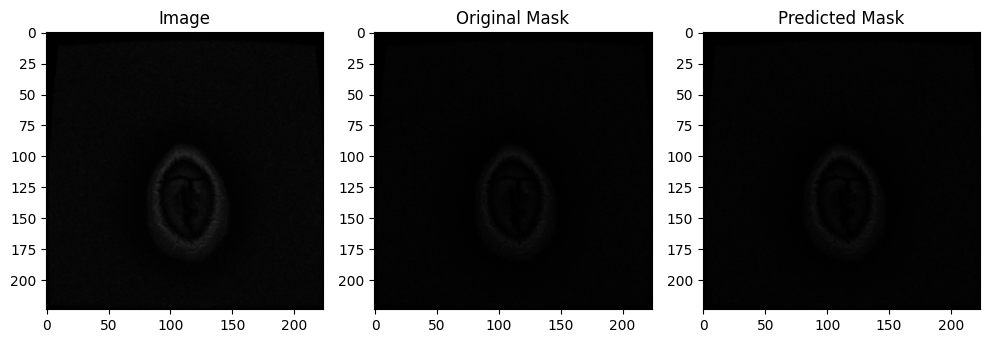

INFO: Early stopping counter 7 of 8
epoch: 14 	step: 1 / 47 	train loss: 0.2652 	train accuracy: 0.9845 	time: 16.2181 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 14 / 41 	train loss: 0.2296 	valid loss: 0.1900 	train accuracy 0.9908 	valid accuracy 0.9899


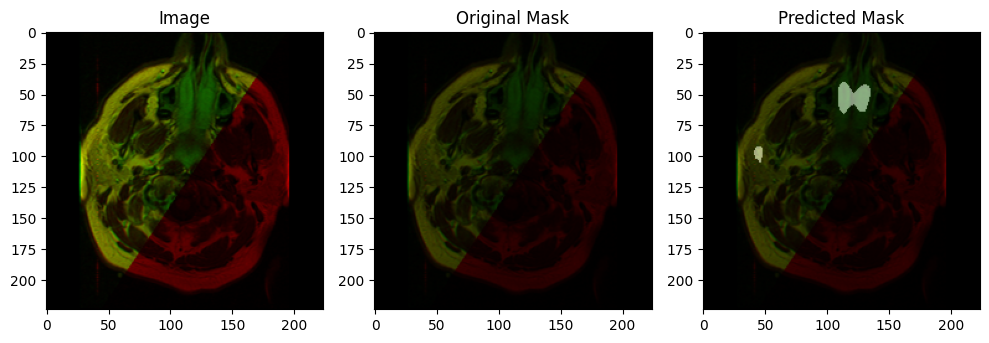

INFO: Early stopping counter 8 of 8
INFO: Early stopping
epoch: 15 	step: 1 / 47 	train loss: 0.2523 	train accuracy: 0.9910 	time: 16.5162 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 15 / 41 	train loss: 0.2232 	valid loss: 0.1505 	train accuracy 0.9913 	valid accuracy 0.9903


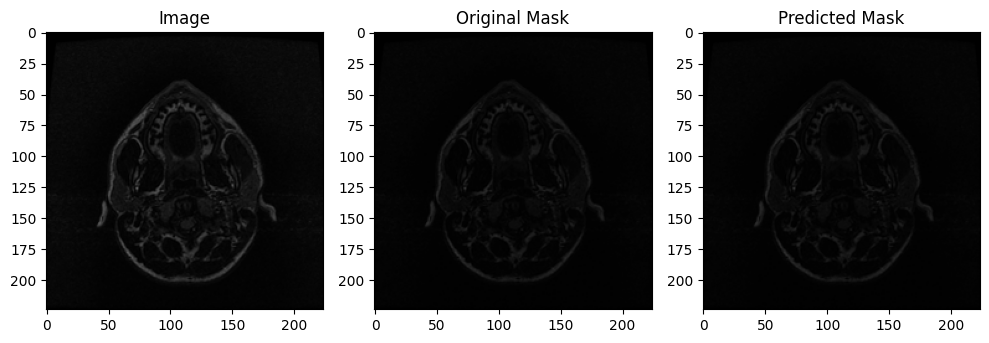

INFO: Early stopping counter 9 of 8
INFO: Early stopping
epoch: 16 	step: 1 / 47 	train loss: 0.1741 	train accuracy: 0.9907 	time: 17.4727 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 16 / 41 	train loss: 0.2244 	valid loss: 0.2000 	train accuracy 0.9911 	valid accuracy 0.9904


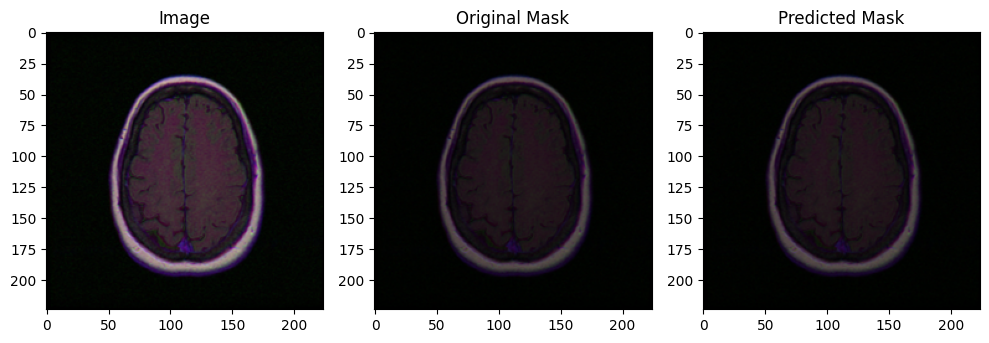

INFO: Early stopping counter 10 of 8
INFO: Early stopping
epoch: 17 	step: 1 / 47 	train loss: 0.2476 	train accuracy: 0.9923 	time: 22.6690 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 17 / 41 	train loss: 0.2157 	valid loss: 0.1605 	train accuracy 0.9915 	valid accuracy 0.9901


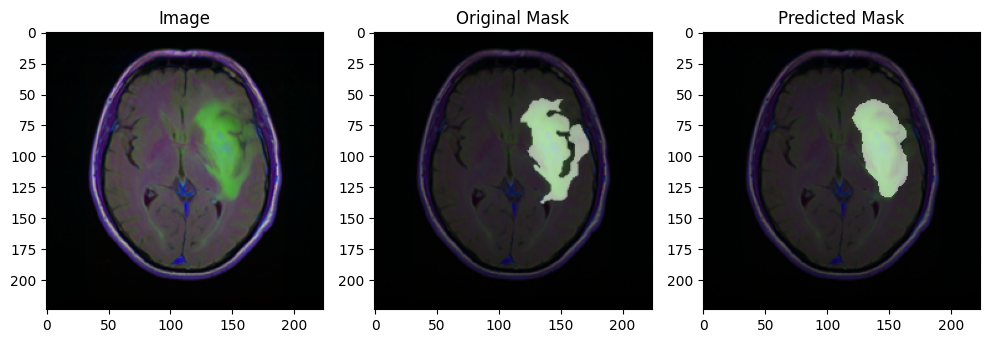

INFO: Early stopping counter 11 of 8
INFO: Early stopping
epoch: 18 	step: 1 / 47 	train loss: 0.1782 	train accuracy: 0.9943 	time: 17.0712 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 18 / 41 	train loss: 0.2279 	valid loss: 0.2442 	train accuracy 0.9908 	valid accuracy 0.9897


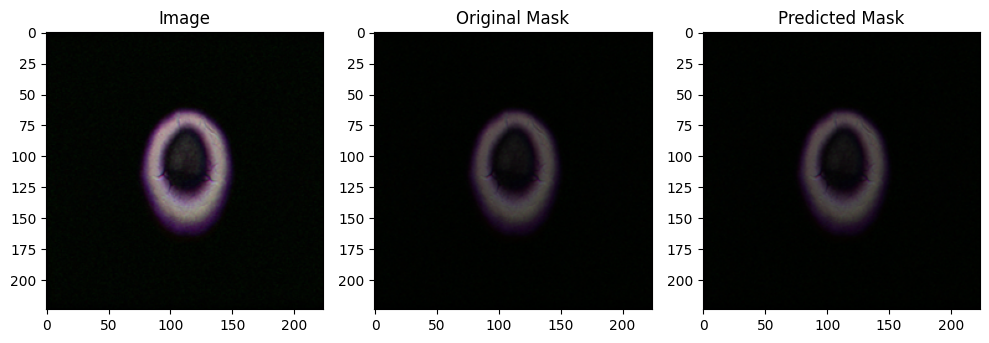

INFO: Early stopping counter 12 of 8
INFO: Early stopping
epoch: 19 	step: 1 / 47 	train loss: 0.2399 	train accuracy: 0.9893 	time: 16.7158 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 19 / 41 	train loss: 0.2193 	valid loss: 0.1922 	train accuracy 0.9912 	valid accuracy 0.9901


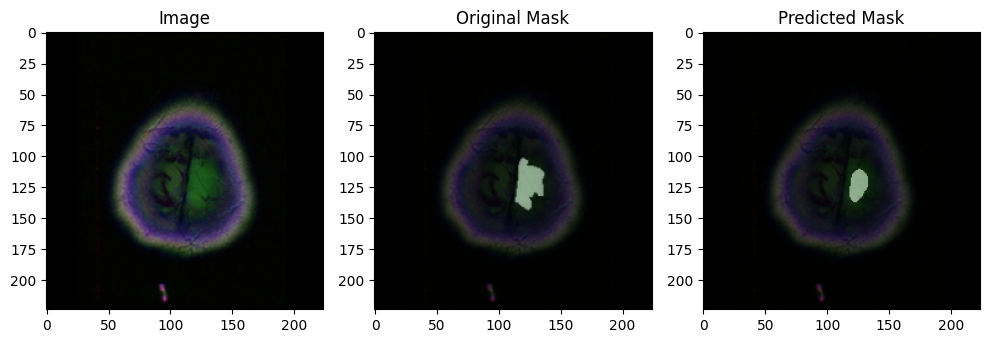

INFO: Early stopping counter 13 of 8
INFO: Early stopping
epoch: 20 	step: 1 / 47 	train loss: 0.2376 	train accuracy: 0.9947 	time: 45.2482 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 20 / 41 	train loss: 0.2132 	valid loss: 0.2339 	train accuracy 0.9910 	valid accuracy 0.9899


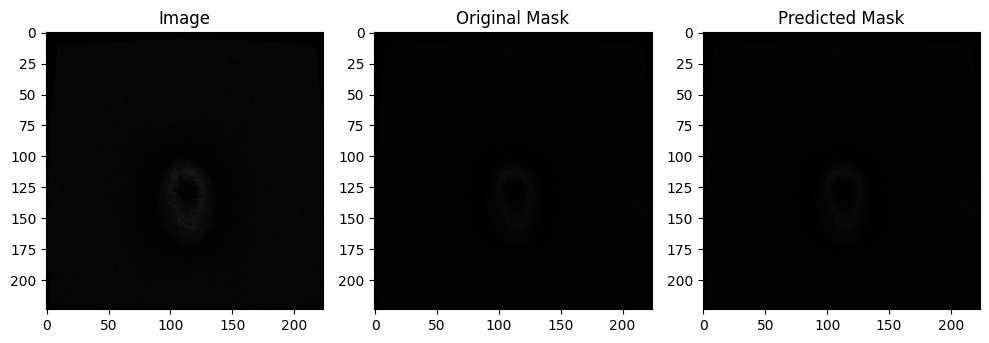

INFO: Early stopping counter 14 of 8
INFO: Early stopping
epoch: 21 	step: 1 / 47 	train loss: 0.2298 	train accuracy: 0.9977 	time: 24.6624 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 21 / 41 	train loss: 0.2097 	valid loss: 0.2026 	train accuracy 0.9915 	valid accuracy 0.9901


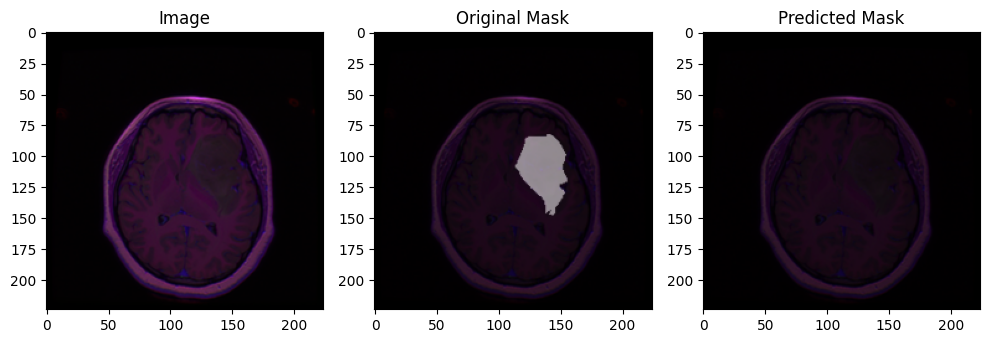

INFO: Early stopping counter 15 of 8
INFO: Early stopping
epoch: 22 	step: 1 / 47 	train loss: 0.1448 	train accuracy: 0.9948 	time: 16.7433 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 22 / 41 	train loss: 0.2103 	valid loss: 0.2293 	train accuracy 0.9913 	valid accuracy 0.9900


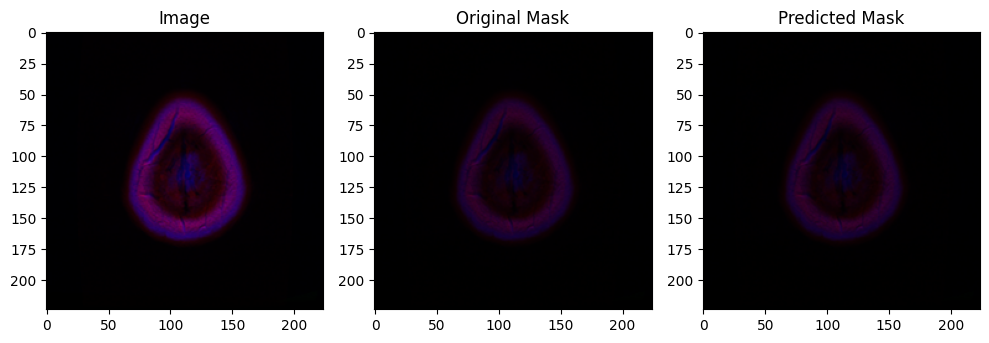

INFO: Early stopping counter 16 of 8
INFO: Early stopping
epoch: 23 	step: 1 / 47 	train loss: 0.2268 	train accuracy: 0.9972 	time: 18.7756 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 23 / 41 	train loss: 0.2075 	valid loss: 0.1858 	train accuracy 0.9912 	valid accuracy 0.9902


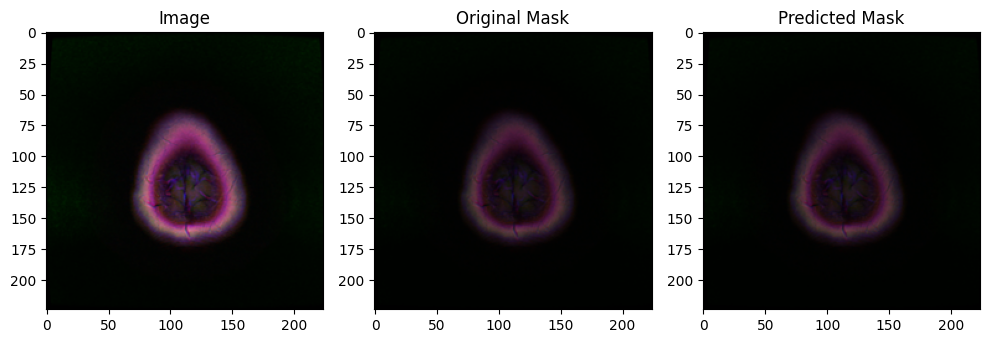

INFO: Early stopping counter 17 of 8
INFO: Early stopping
epoch: 24 	step: 1 / 47 	train loss: 0.1498 	train accuracy: 0.9929 	time: 19.8166 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 24 / 41 	train loss: 0.2153 	valid loss: 0.1821 	train accuracy 0.9915 	valid accuracy 0.9903


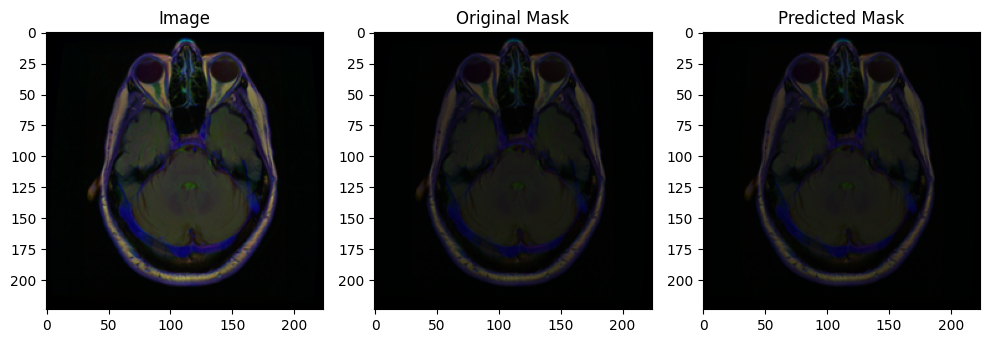

INFO: Early stopping counter 18 of 8
INFO: Early stopping
epoch: 25 	step: 1 / 47 	train loss: 0.2373 	train accuracy: 0.9900 	time: 17.4969 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 25 / 41 	train loss: 0.2139 	valid loss: 0.1938 	train accuracy 0.9911 	valid accuracy 0.9903


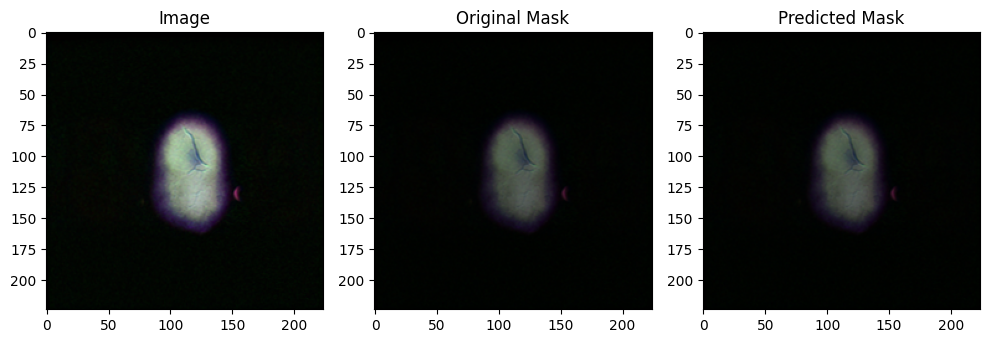

INFO: Early stopping counter 19 of 8
INFO: Early stopping
epoch: 26 	step: 1 / 47 	train loss: 0.2375 	train accuracy: 0.9912 	time: 21.5693 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 26 / 41 	train loss: 0.2110 	valid loss: 0.2045 	train accuracy 0.9916 	valid accuracy 0.9903


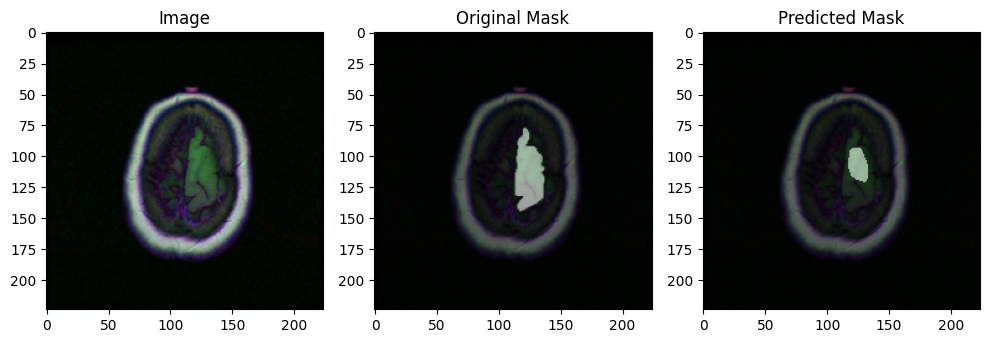

INFO: Early stopping counter 20 of 8
INFO: Early stopping
epoch: 27 	step: 1 / 47 	train loss: 0.2553 	train accuracy: 0.9846 	time: 16.6942 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 27 / 41 	train loss: 0.2214 	valid loss: 0.2091 	train accuracy 0.9909 	valid accuracy 0.9902


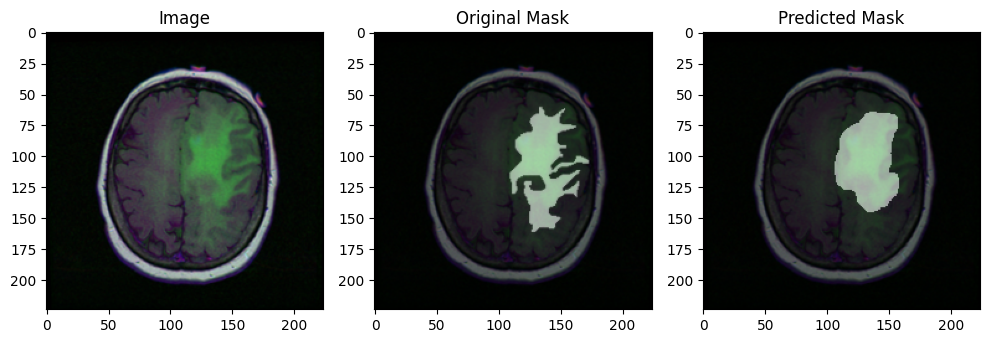

INFO: Early stopping counter 21 of 8
INFO: Early stopping
epoch: 28 	step: 1 / 47 	train loss: 0.2281 	train accuracy: 1.0000 	time: 16.7496 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 28 / 41 	train loss: 0.2155 	valid loss: 0.2175 	train accuracy 0.9907 	valid accuracy 0.9901


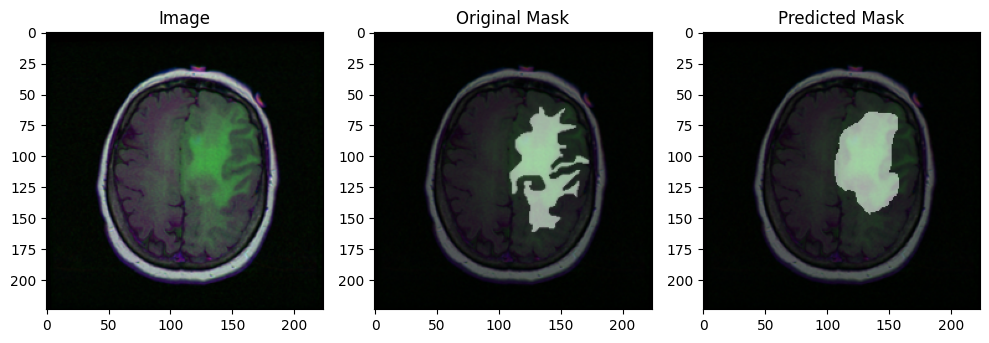

INFO: Early stopping counter 22 of 8
INFO: Early stopping
epoch: 29 	step: 1 / 47 	train loss: 0.1923 	train accuracy: 0.9915 	time: 16.7629 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 29 / 41 	train loss: 0.2109 	valid loss: 0.1952 	train accuracy 0.9915 	valid accuracy 0.9903


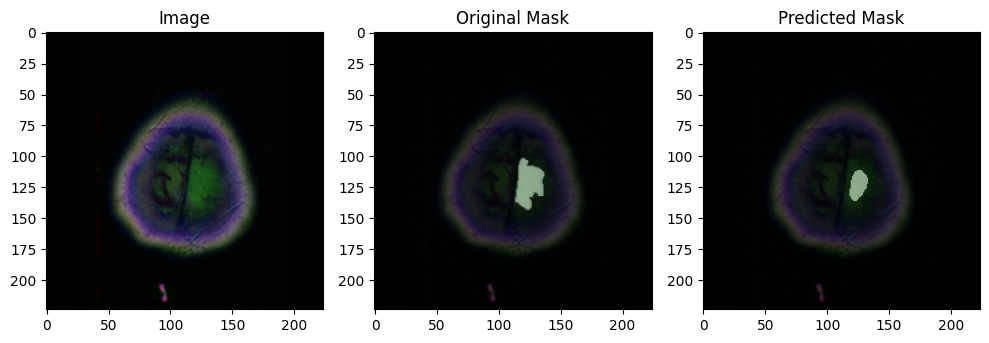

INFO: Early stopping counter 23 of 8
INFO: Early stopping
epoch: 30 	step: 1 / 47 	train loss: 0.2330 	train accuracy: 0.9932 	time: 24.2862 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 30 / 41 	train loss: 0.2265 	valid loss: 0.1915 	train accuracy 0.9915 	valid accuracy 0.9903


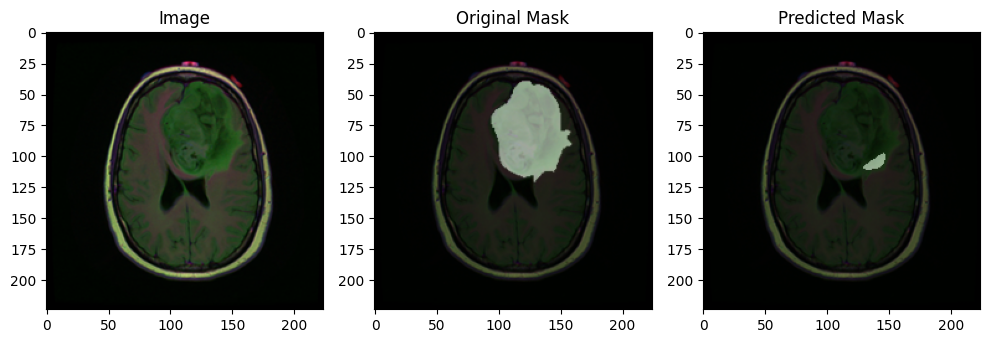

INFO: Early stopping counter 24 of 8
INFO: Early stopping
epoch: 31 	step: 1 / 47 	train loss: 0.1454 	train accuracy: 0.9918 	time: 24.0057 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 31 / 41 	train loss: 0.2072 	valid loss: 0.2010 	train accuracy 0.9910 	valid accuracy 0.9903


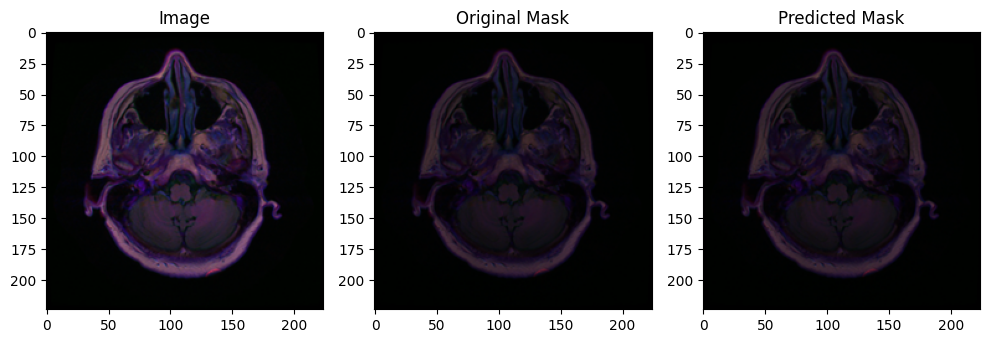

INFO: Early stopping counter 25 of 8
INFO: Early stopping
epoch: 32 	step: 1 / 47 	train loss: 0.2464 	train accuracy: 0.9841 	time: 23.2105 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 32 / 41 	train loss: 0.2102 	valid loss: 0.2027 	train accuracy 0.9917 	valid accuracy 0.9902


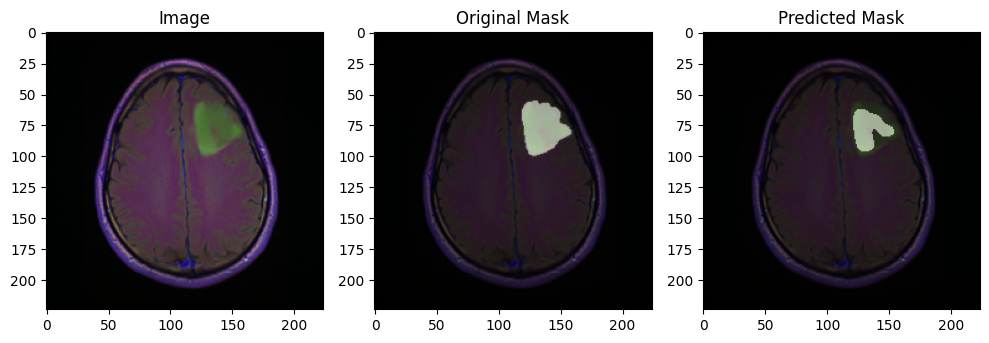

INFO: Early stopping counter 26 of 8
INFO: Early stopping
epoch: 33 	step: 1 / 47 	train loss: 0.1807 	train accuracy: 0.9973 	time: 27.2470 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 33 / 41 	train loss: 0.2194 	valid loss: 0.2181 	train accuracy 0.9912 	valid accuracy 0.9902


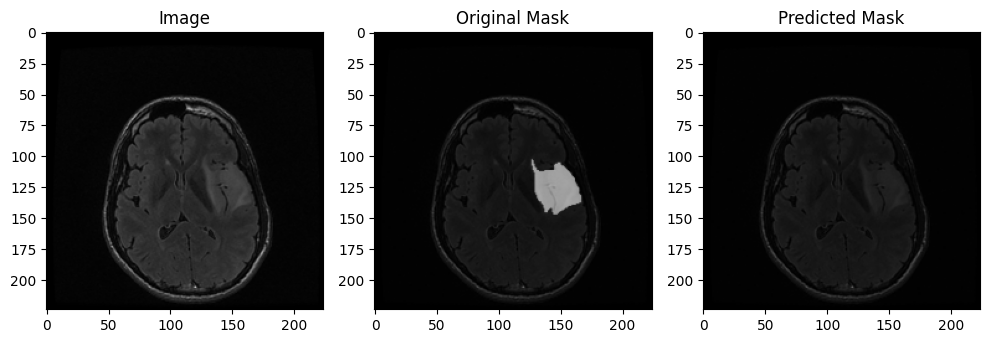

INFO: Early stopping counter 27 of 8
INFO: Early stopping
epoch: 34 	step: 1 / 47 	train loss: 0.2290 	train accuracy: 0.9988 	time: 26.9825 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 34 / 41 	train loss: 0.2259 	valid loss: 0.2196 	train accuracy 0.9909 	valid accuracy 0.9902


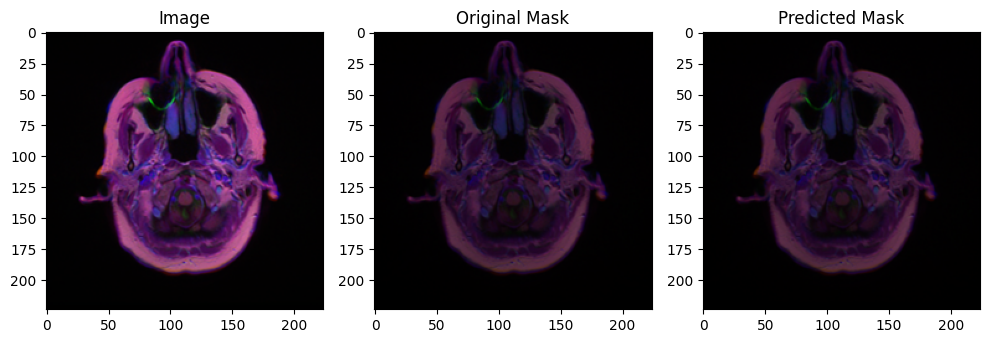

INFO: Early stopping counter 28 of 8
INFO: Early stopping
epoch: 35 	step: 1 / 47 	train loss: 0.2057 	train accuracy: 0.9923 	time: 25.8544 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 35 / 41 	train loss: 0.2103 	valid loss: 0.1906 	train accuracy 0.9916 	valid accuracy 0.9903


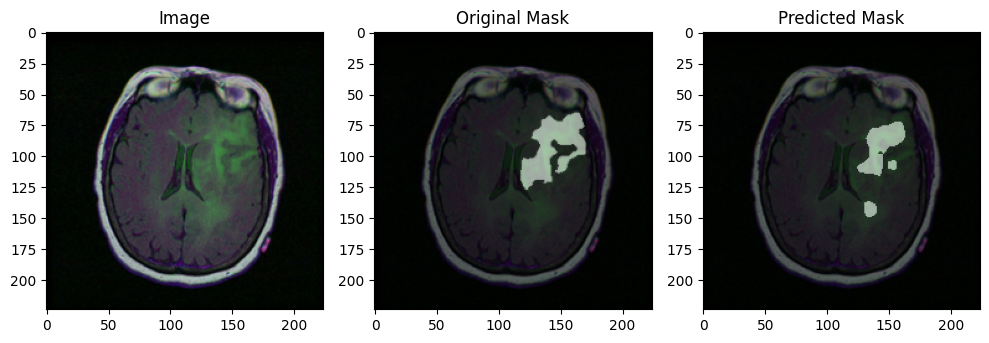

INFO: Early stopping counter 29 of 8
INFO: Early stopping
epoch: 36 	step: 1 / 47 	train loss: 0.1507 	train accuracy: 0.9946 	time: 16.5571 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 36 / 41 	train loss: 0.2120 	valid loss: 0.2211 	train accuracy 0.9909 	valid accuracy 0.9901


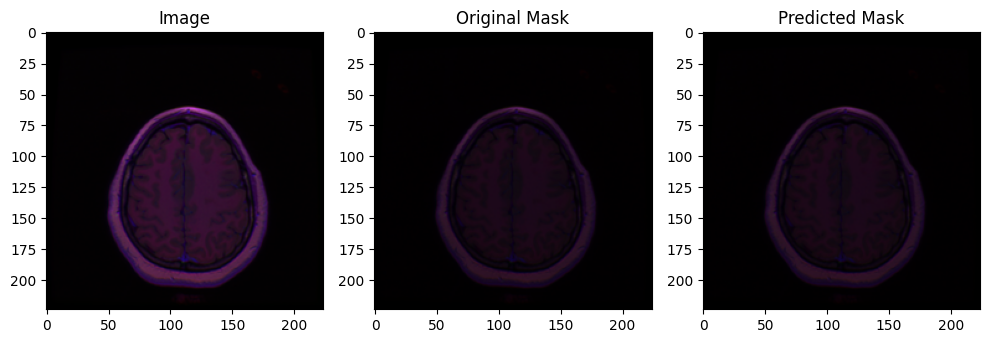

INFO: Early stopping counter 30 of 8
INFO: Early stopping
epoch: 37 	step: 1 / 47 	train loss: 0.1985 	train accuracy: 0.9910 	time: 16.7608 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 37 / 41 	train loss: 0.2173 	valid loss: 0.2270 	train accuracy 0.9914 	valid accuracy 0.9901


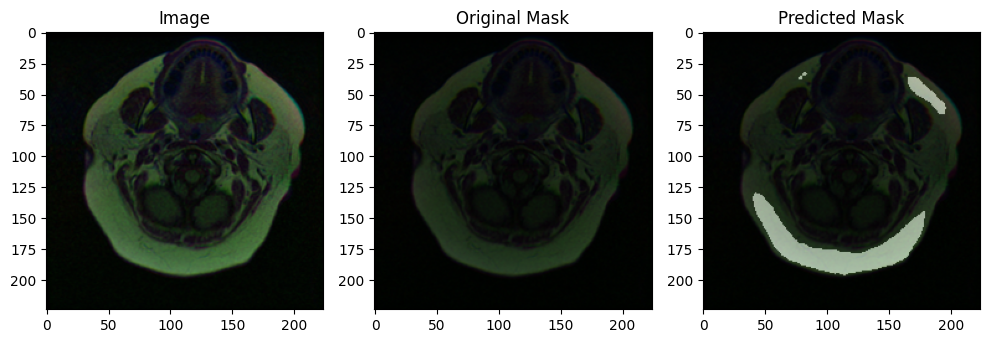

INFO: Early stopping counter 31 of 8
INFO: Early stopping
epoch: 38 	step: 1 / 47 	train loss: 0.1609 	train accuracy: 0.9957 	time: 16.6309 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 38 / 41 	train loss: 0.2098 	valid loss: 0.2109 	train accuracy 0.9916 	valid accuracy 0.9902


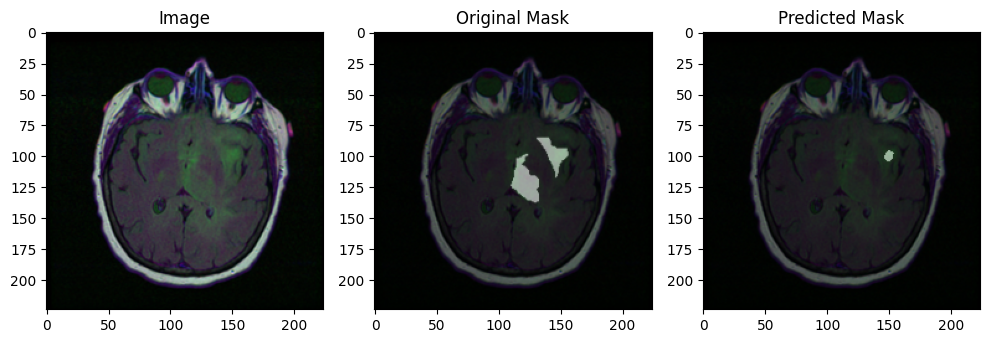

INFO: Early stopping counter 32 of 8
INFO: Early stopping
epoch: 39 	step: 1 / 47 	train loss: 0.1971 	train accuracy: 0.9909 	time: 16.5438 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 39 / 41 	train loss: 0.2131 	valid loss: 0.2372 	train accuracy 0.9912 	valid accuracy 0.9901


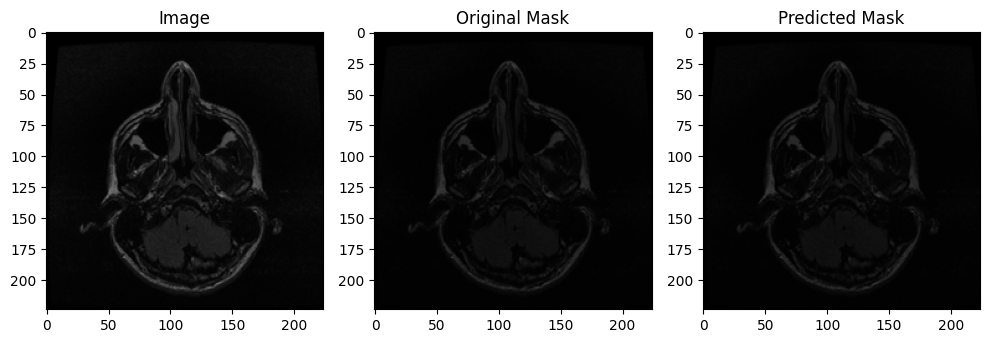

INFO: Early stopping counter 33 of 8
INFO: Early stopping
epoch: 40 	step: 1 / 47 	train loss: 0.2459 	train accuracy: 0.9849 	time: 23.1285 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 40 / 41 	train loss: 0.2132 	valid loss: 0.2161 	train accuracy 0.9908 	valid accuracy 0.9902


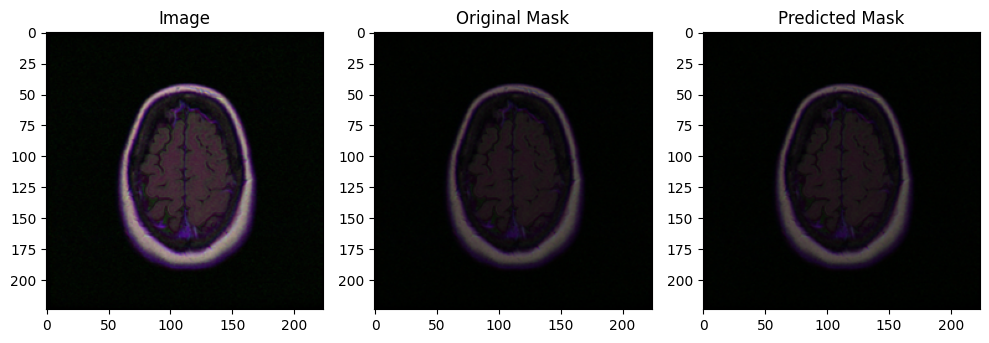

INFO: Early stopping counter 34 of 8
INFO: Early stopping


In [ ]:
import time

for epoch in range(1,  EPOCHS+1):

    train_loss, train_accs = [], []
    for step, batch in enumerate(train_dl):
        time_1 = time.time()

        loss, accuracy = train_one_batch(batch, model, optimizer, criterion)

        train_loss.append(loss)
        train_accs.append(accuracy)

        if step % print_feq == 0:
            print('epoch:', epoch,
                  '\tstep:', step+1, '/', len(train_dl) + 1,
                  '\ttrain loss:', '{:.4f}'.format(loss),
                  '\ttrain accuracy:','{:.4f}'.format(accuracy),
                  '\ttime:', '{:.4f}'.format((time.time()-time_1)*print_feq), 's')

    valid_loss, valid_accs = [], []
    for step, batch in enumerate(tqdm(valid_dl)):
        loss, accuracy = validate_one_batch(batch, model, criterion)

        valid_loss.append(loss)
        valid_accs.append(accuracy)

    print('epoch:', epoch, '/', EPOCHS+1,
            '\ttrain loss:', '{:.4f}'.format(np.mean(train_loss)),
            '\tvalid loss:', '{:.4f}'.format(np.mean(valid_loss)),
            '\ttrain accuracy', '{:.4f}'.format(np.mean(train_accs)),
            '\tvalid accuracy', '{:.4f}'.format(np.mean(valid_accs)))

    test_plot(model)

    stopper(np.mean(valid_loss))
    scheduler.step(np.mean(valid_loss))

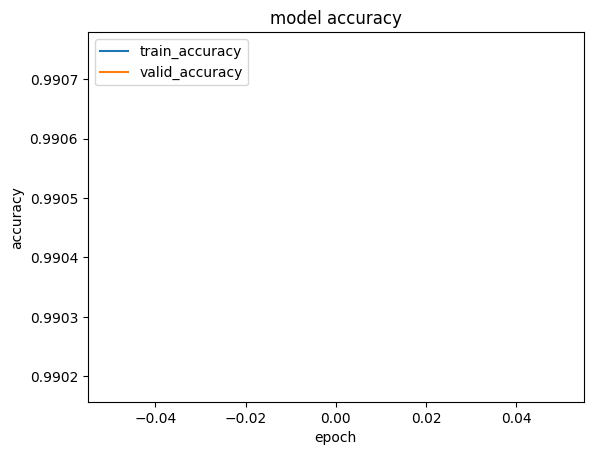

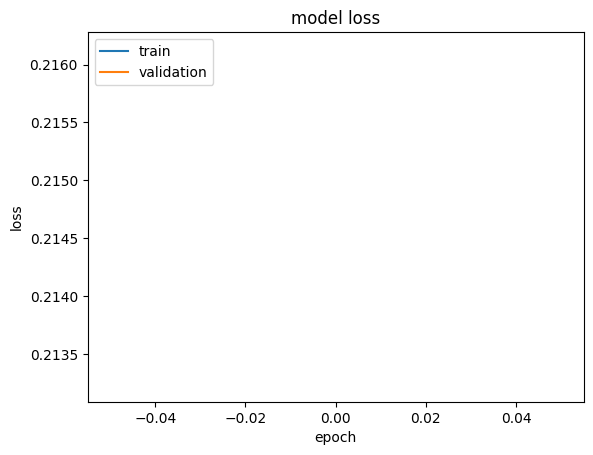

In [ ]:
plt.plot(np.mean(train_accs))
plt.plot(np.mean(valid_accs))
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'valid_accuracy'], loc='upper left')
plt.show()
# "Loss"
plt.plot(np.mean(train_loss))
plt.plot(np.mean(valid_loss))
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


In [ ]:
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score